### Кейс № 2 
### "Выявление мошеннических транзакций по банковским кредитным картам"

### Постановка задачи:

Датасет содержит информацию банка N о транзакциях по кредитным картам за два дня. В сильно дисбалансированной выборке присутствует 492 случая мошеннических транзакций и 284807 легитимных транзакций.

### Всего 30 признаков
Time: время задержки между текущей и первой транзакцией в датасете (сек)

Amount: сумма транзакции

V1: обезличенный преобразованный признак

V2: обезличенный преобразованный признак

...

V28: обезличеннный преобразованный признак

Class: Тип транзакции (1=yes, 0=no)

### Вопросы:
#### 1. Какова вероятность, что транзакция является мошеннической?
#### 2. Какие признаки наиболее значимы в контексте задачи?

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
from sklearn import manifold
import operator
import math
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro
import statsmodels.api as sm
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
data =  pd.read_csv("creditcard.csv",sep=",", header=0)

In [4]:
data.shape

(284807, 31)

In [5]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
y = data['Class']
X = data.drop(['Class'],axis=1)

### Проверяем на наличие NaN

In [7]:
for col in data.columns:
    nan_numbers = data[pd.isnull(data[col])].shape[0]
    if nan_numbers > 0:
        print(col, nan_numbers)

### Смотрим на соотношение классов в выборке

In [8]:
print ("Normal transaction 0: {}, \n Fraud transaction 1: {}".format(
    1.0-(y.sum()/float(len(y))),
    y.sum()/float(len(y)))) 

Normal transaction 0: 0.9982725143693799, 
 Fraud transaction 1: 0.001727485630620034


### Проверяем формат данных

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

### Статистика по выборке 

In [10]:
data.describe().T[data.describe().T['max'] > 0]

,count,mean,std,min,25%,50%,75%,max
Time,284807.0,9.481386e+04,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.0,3.919560e-15,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.0,5.688174e-16,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.0,-8.769071e-15,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.0,2.782312e-15,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.0,-1.552563e-15,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.0,2.010663e-15,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.0,-1.694249e-15,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.0,-1.927028e-16,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.0,-3.137024e-15,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [11]:
data.isnull().any()

Time      False
V1        False
V2        False
V3        False
V4        False
V5        False
V6        False
V7        False
V8        False
V9        False
V10       False
V11       False
V12       False
V13       False
V14       False
V15       False
V16       False
V17       False
V18       False
V19       False
V20       False
V21       False
V22       False
V23       False
V24       False
V25       False
V26       False
V27       False
V28       False
Amount    False
Class     False
dtype: bool

### Строим функции плотности вероятности для признаков и смотрим на распределения

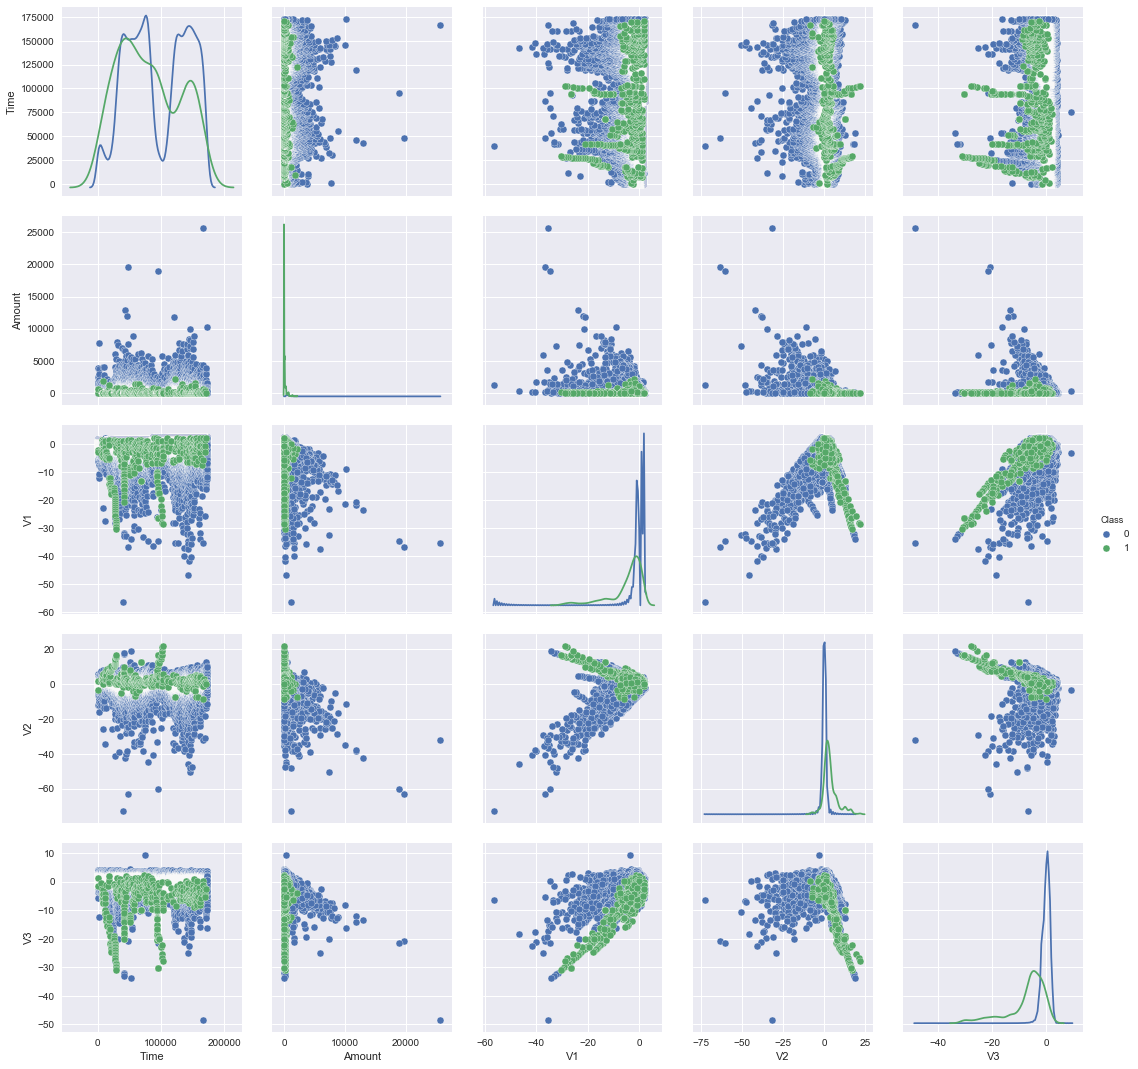

In [12]:
plot_features = ['Time', 'Amount', 'V1', 'V2', 'V3']
X_y = pd.concat((data[plot_features], data['Class']), axis=1)
new_palette = sns.color_palette("Paired")
#sns.palplot(new_palette)
sns.pairplot(X_y, vars=plot_features, hue="Class", size=3, diag_kind="kde")

### Строим функции плотности вероятности для признаков и смотрим на распределения

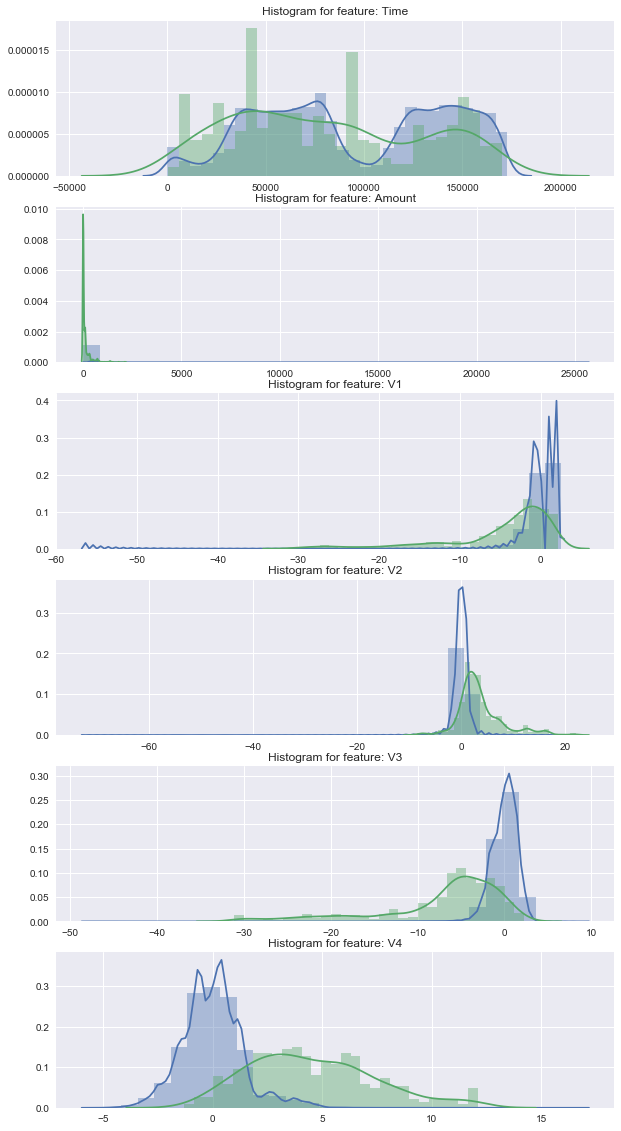

In [13]:
plot_features = ['Time', 'Amount', 'V1', 'V2', 'V3', 'V4']
plt.figure(figsize=(10,20))
grids = gridspec.GridSpec(len(plot_features),1)
for i,j in enumerate(data[plot_features]):
    ax = plt.subplot(grids[i])
    sns.distplot(data[j][data.Class == 0], bins=30)
    sns.distplot(data[j][data.Class == 1], bins=30)
    ax.set_xlabel('')
    #ax.set_xlim(-2,2)
    ax.set_title('Histogram for feature: ' + str(j))
plt.show()

### Проверка на логнормальность признаков

In [14]:
feat1 = X['Amount']
feat1_log = np.log(abs(X['Amount'])+1)

In [15]:
print(shapiro(feat1),shapiro(feat1_log))

(0.3100607991218567, 0.0) (0.9798502922058105, 0.0)


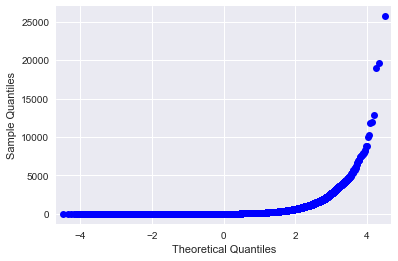

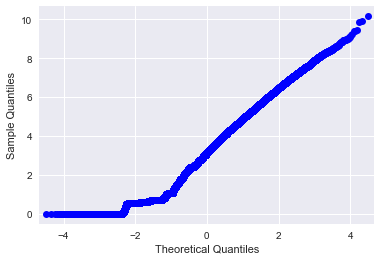

In [16]:
sm.qqplot(feat1, loc=feat1.mean(), scale=feat1.std())
sm.qqplot(feat1_log, loc=feat1_log.mean(), scale=feat1_log.std())
plt.show()

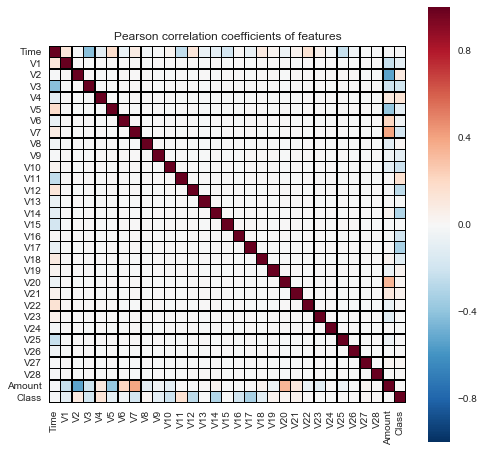

In [17]:
f, ax = plt.subplots(figsize=(8, 8))
plt.title('Pearson correlation coefficients of features')
sns.heatmap(data.astype(float).corr(),linewidths=0.25,vmax=1.0, square=True, linecolor='black')

### Смотрим на корреляции признаков с целевой переменной

In [18]:
def CorrelationSelector(X,y):
    columns = X.columns
    corr_data = dict([(abs(np.corrcoef(X[c],y)[0,1]),c) for c in columns if math.isnan(abs(np.corrcoef(X[c],y)[0,1]))==False])
    sorted_corr_data = sorted(corr_data.items(), key=operator.itemgetter(0), reverse=True)
    return sorted_corr_data

In [19]:
CorrelationSelector(X,y)

[(0.32648106724371911, 'V17'),
 (0.3025436958044091, 'V14'),
 (0.26059292487722191, 'V12'),
 (0.2168829436410312, 'V10'),
 (0.19653894030402153, 'V16'),
 (0.1929608270674163, 'V3'),
 (0.1872565915143011, 'V7'),
 (0.15487564474394991, 'V11'),
 (0.1334474862390066, 'V4'),
 (0.11148525388904272, 'V18'),
 (0.10134729859508675, 'V1'),
 (0.097732686074080463, 'V9'),
 (0.094974298991450046, 'V5'),
 (0.091288650344620803, 'V2'),
 (0.043643160699964677, 'V6'),
 (0.040413380610576193, 'V21'),
 (0.034783013036515445, 'V19'),
 (0.020090324196975699, 'V20'),
 (0.019875123914794613, 'V8'),
 (0.017579728189513581, 'V27'),
 (0.012322570929245826, 'Time'),
 (0.0095360409162363394, 'V28'),
 (0.0072209067159528257, 'V24'),
 (0.0056317530067686366, 'Amount'),
 (0.0045697787994613305, 'V13'),
 (0.0044553975012834096, 'V26'),
 (0.0042234022678567509, 'V15'),
 (0.0033077055972997012, 'V25'),
 (0.0026851557402507273, 'V23'),
 (0.00080531750529848312, 'V22')]

### Посмотрим, насколько можем понизить размерность задачи без значительно потери информации

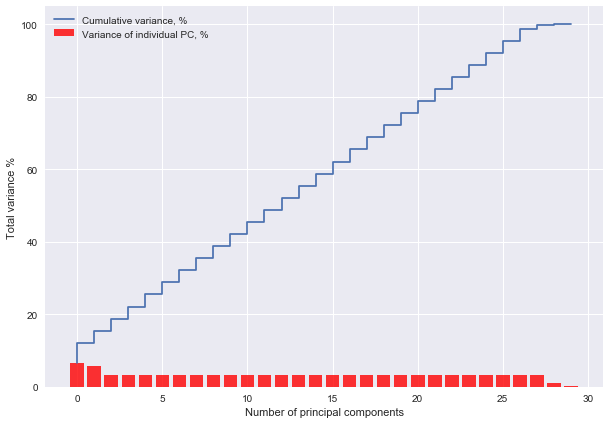

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
from numpy.linalg import eig
covX = np.cov(X_scaled.T)
eigs, vecs = eig(covX)
eig_pairs = [(abs(eigs[i]),vecs[:,i]) for i in range(len(eigs))]
eig_pairs.sort(key = lambda x: x[0], reverse= True)
E = sum(eigs)
exp_variance = [(i/E)*100 for i in sorted(eigs, reverse=True)] # Individual explained variance
cum_variance = np.cumsum(exp_variance) # Cumulative explained variance

plt.figure(figsize=(10,7))
plt.bar(range(len(eigs)), exp_variance, alpha=0.8, label='Variance of individual PC, %', color = 'r')
plt.step(range(len(eigs)), cum_variance, label='Cumulative variance, %')
plt.ylabel('Total variance %')
plt.xlabel('Number of principal components')
plt.legend()
plt.show()

### Визуализация подвыборки

In [21]:
data_sample = pd.concat([
    data[data['Class'] == 1].sample(frac=1, random_state=1),
    data[data['Class'] != 1].sample(frac=0.02, random_state=1)
])
y_sample = data_sample['Class']
X_sample = data_sample.drop(['Class'],axis=1)

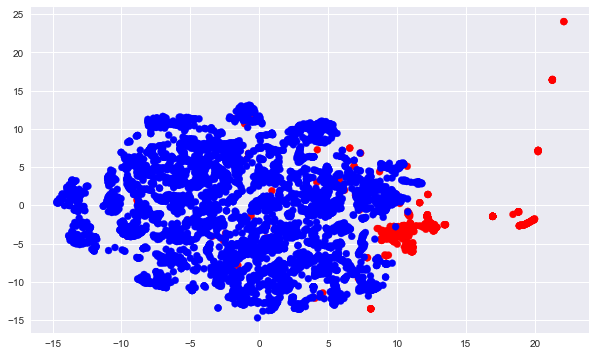

In [22]:
# Визуализация сбалансированных данных
scaler = StandardScaler() # для t-sne обязательно нужна стандартизация признаков
X_sample_sc = scaler.fit_transform(X_sample)
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
data_2d_tsne = tsne.fit_transform(X_sample_sc)

colors = ListedColormap(['blue', 'red'])
plt.figure(figsize = (10, 6))
plt.scatter(data_2d_tsne[:,0], data_2d_tsne[:,1], c = y_sample, cmap = colors)
plt.legend(loc='best')
plt.show()

In [23]:
def data_preprocess(data):
    final_data = data.copy()
    
    #std_scaler = StandardScaler()
    #final_data = std_scaler.fit_transform(final_data)


    
    return final_data

In [24]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        1#print('Confusion matrix, without normalization')

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Разбиваем выборку на обучающую и валидационную
На обучающей выборке будем обучать модели с разными параметрами на кросс-валидации.
Лучшие модели проверим на отложенной выборке

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.3, random_state=0)

In [26]:
features = data_preprocess(X_train)
labels = y_train
train_feat = features
train_labels = labels

In [27]:
print(sum(y_train), sum(y_test))

342 150


### Подбираем параметры перебором по сетке

In [28]:
def show_cv(clf_i, name, f, l, cv, score='roc_auc', param=None, vbs=False):
    if param: 
        grid_cv = GridSearchCV(
            clf_i,
            param,
            scoring=score,
            cv=cv,
            verbose=vbs,
            n_jobs=-1
        )
        grid_cv.fit(f, l)
        clf_i = grid_cv.best_estimator_
        print(grid_cv.best_params_)
    score = cross_val_score(clf_i,f,l,cv=cv, scoring=score, n_jobs=-1)
    print(name, score.mean(), score)

### Обучим модели на параметрах "из коробки"

In [29]:
scaler = StandardScaler()
model_rf = RandomForestClassifier(n_estimators=100)
model_lr = LogisticRegression()
model_svm = LinearSVC()
model_t = DecisionTreeClassifier()
model_gb = GradientBoostingClassifier(n_estimators=100)
pipeline_svm = make_pipeline(scaler, model_svm)
pipeline_lr = make_pipeline(scaler, model_lr)

clfs = [
    ['DTree', model_t],
    ['LR', model_lr],
    ['LR_scalled', pipeline_lr],
    ['Linear_SVM', model_svm],
    ['SVM_scalled', pipeline_svm],
    ['RF', model_rf],
    ['GB', model_gb],
]

Kf = StratifiedKFold(labels, n_folds=3, shuffle=True, random_state=2)
for name, cl in clfs:
    show_cv(cl, name, features, labels, Kf)

DTree 0.924631822282 [ 0.90913655  0.93907905  0.92567987]
LR 0.905091737539 [ 0.83856479  0.95839448  0.91831595]
LR_scalled 0.981533447809 [ 0.98025655  0.9810217   0.9833221 ]
Linear_SVM 0.772221623906 [ 0.70676786  0.77889713  0.83099988]
SVM_scalled 0.980480602456 [ 0.97865145  0.98014252  0.98264784]
RF 0.976722452881 [ 0.98370456  0.98906318  0.95739962]
GB 0.986093119321 [ 0.986099    0.98633311  0.98584725]


### Подбор параметров моделей по кросс-валидации 

In [30]:
clfs = [
    ['LR', model_lr],
    ['LR_scalled', pipeline_lr],
    ['SVM_scalled', pipeline_svm],
    ['RF', model_rf],
    ['GB', model_gb],
]
parameters={
    'LR': {
        'C': np.arange(0.0000001, 0.5, 0.05),
        'penalty': ['l1','l2'],
        'class_weight': [
            None,
            'balanced',
            {0:0.1, 1:0.9},
            {0:0.01, 1:0.99},
            {0:0.001, 1:0.999}
        ]
    },
    'LR_scalled': {
        'logisticregression__C': np.arange(0.0000001, 0.5, 0.05),
        'logisticregression__penalty': ['l1','l2'],
        'logisticregression__class_weight': [
            None,
            'balanced',
             {0:0.1, 1:0.9},
            {0:0.01, 1:0.99},
            {0:0.001, 1:0.999}
        ]
    },
    'SVM_scalled': {
        'linearsvc__C': np.arange(0.0000001, 0.5, 0.05),
        'linearsvc__penalty': ['l2'],
        'linearsvc__class_weight': [
            None,
            'balanced',
             {0:0.1, 1:0.9},
            {0:0.01, 1:0.99},
            {0:0.001, 1:0.999}
        ]
    },
    'RF': {
        'n_estimators': [50, 100, 200, 500],
        'max_depth': [8,10,15],
        'min_samples_split': [2,5],
        'min_samples_leaf': [2,5],
    },
    'GB': {
        'n_estimators': [50, 100, 200, 500],
        'learning_rate': np.linspace(0.00001, 0.5, num=5),
        'max_depth': [3,5,7],
    },

}

for name, cl in clfs:
    show_cv(cl, name, features, labels, Kf, param=parameters.get(name), vbs=True)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.7s finished


{'class_weight': {0: 0.01, 1: 0.99}, 'C': 0.35000010000000004, 'penalty': 'l1'}
LR 0.984795847943 [ 0.98386969  0.98705033  0.98346752]
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done  47 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 293 out of 300 | elapsed:   10.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   10.4s finished


{'logisticregression__penalty': 'l1', 'logisticregression__class_weight': 'balanced', 'logisticregression__C': 0.050000100000000006}
LR_scalled 0.985403271423 [ 0.98676945  0.98495485  0.98448552]
Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.8s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:   11.4s finished


{'linearsvc__penalty': 'l2', 'linearsvc__C': 0.050000100000000006, 'linearsvc__class_weight': {0: 0.1, 1: 0.9}}
SVM_scalled 0.982973315345 [ 0.984986    0.98056558  0.98336837]
Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   32.6s
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed:  2.1min finished


{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15, 'n_estimators': 500}
RF 0.983755020346 [ 0.98705348  0.98835257  0.97585901]
Fitting 3 folds for each of 60 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   55.4s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  2.1min finished


{'n_estimators': 200, 'learning_rate': 0.25000499999999998, 'max_depth': 5}
GB 0.983880550561 [ 0.97854576  0.98643557  0.98666032]


In [31]:
features = data_preprocess(X_test)
labels = y_test
test_feat = features
test_labels = labels

In [32]:
print(sum(train_labels), len(train_feat), sum(test_labels), len(test_feat))

342 4324 150 1854


In [33]:
scaler = StandardScaler()
final_model1 = LogisticRegression(class_weight={0: 0.01, 1: 0.99}, C=0.35, penalty='l1')
final_model2 = make_pipeline(scaler, LogisticRegression(class_weight='balanced', C=0.05, penalty='l1'))
final_model3 = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.25,
    max_depth=5
)
final_model4 = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=2,
    min_samples_leaf=2,
    n_jobs=-1
)

In [34]:
final_model1.fit(train_feat, train_labels)
final_model2.fit(train_feat, train_labels)
final_model3.fit(train_feat, train_labels)
final_model4.fit(train_feat, train_labels)

predict = []
predict.append(final_model1.predict_proba(test_feat))
predict.append(final_model2.predict_proba(test_feat))
predict.append(final_model3.predict_proba(test_feat))
predict.append(final_model4.predict_proba(test_feat))

for n, model_name in enumerate(['LR', 'LR_scalled', 'GB', 'RF']):
    print(model_name, roc_auc_score(test_labels, [x[1] for x in predict[n]]))

LR 0.965148669797
LR_scalled 0.971799687011
GB 0.979303599374
RF 0.967656494523


In [38]:
test = pd.concat((X_test, y_test), axis=1)
test['predict_LR'] = [x[1] for x in predict[0]]
test['predict_LR_scalled'] = [x[1] for x in predict[1]]
test['predict_GB'] = [x[1] for x in predict[2]]
test['predict_RF'] = [x[1] for x in predict[3]]

final_pred = test[[
    'predict_LR',
    'predict_LR_scalled',
    'predict_GB',
    'predict_RF',
    'Class'
]].sort_values('predict_GB', ascending=False)

final_pred.index = range(final_pred.shape[0])

In [39]:
final_pred.head()

,predict_LR,predict_LR_scalled,predict_GB,predict_RF,Class
0,1.0,1.0,0.999998,0.999333,1
1,1.0,1.0,0.999998,0.975433,1
2,1.0,1.0,0.999996,0.988267,1
3,1.0,1.0,0.999995,0.999000,1
4,1.0,1.0,0.999994,0.999000,1


### ROC-кривые на валидационной выборке

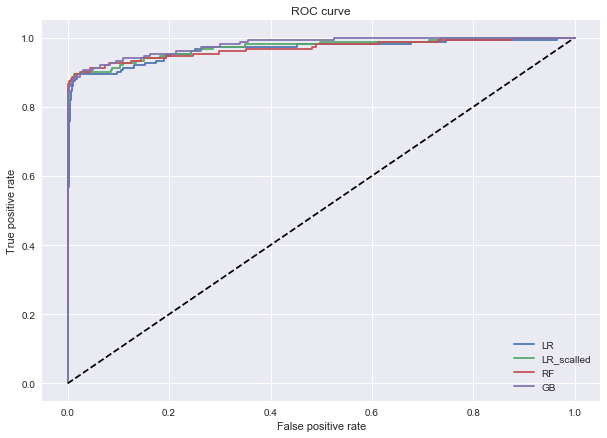

In [41]:
fpr_lr, tpr_lr, _ = roc_curve(final_pred['Class'], final_pred['predict_LR'])
fpr_lr_s, tpr_lr_s, _ = roc_curve(final_pred['Class'], final_pred['predict_LR_scalled'])
fpr_rf, tpr_rf, _ = roc_curve(final_pred['Class'], final_pred['predict_RF'])
fpr_gb, tpr_gb, _ = roc_curve(final_pred['Class'], final_pred['predict_GB'])

plt.figure(figsize=(10,7))
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_lr_s, tpr_lr_s, label='LR_scalled')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_gb, tpr_gb, label='GB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Выводим матрицу ошибок градиентного бустинга над решающими деревьями

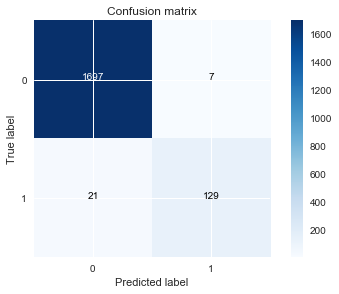

Recall:  [ 1.    0.86] 

Precision:  [ 0.99  0.95] 

AUC ROC:  0.979303599374
AUC PRC:  0.929942961091


In [42]:
# Gradient Boosting by Decision Trees
y_pred = final_model3.predict(test_feat)
y_pred_proba = final_model3.predict_proba(test_feat)[:,1]

conf_matrix = confusion_matrix(test_labels, y_pred)
precision, recall, thresholds = precision_recall_curve(test_labels, y_pred_proba)
np.set_printoptions(precision=2)

class_names = [0,1]
plt.figure()
plot_confusion_matrix(conf_matrix, classes=class_names, title='Confusion matrix')
plt.show()

#print "Confusion matrix:\n", conf_matrix,"\n",
print ("Recall: ", recall_score(test_labels, y_pred, average=None), '\n')
print ("Precision: ", precision_score(test_labels, y_pred, average=None), '\n')
print ("AUC ROC: ", roc_auc_score(test_labels, y_pred_proba))
print ("AUC PRC: ", auc(recall, precision))

### Наиболее значимые признаки согласно лучшей модели

In [43]:
feature_names = X.columns
importances = final_model3.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices):
    print("{:2d}. feature '{:5s}' ({:.4f})".format(f+1, feature_names[idx], importances[idx]))

Feature importances:
 1. feature 'V14  ' (0.0989)
 2. feature 'V12  ' (0.0466)
 3. feature 'V4   ' (0.0431)
 4. feature 'V7   ' (0.0261)
 5. feature 'V26  ' (0.0260)
 6. feature 'V17  ' (0.0251)
 7. feature 'V19  ' (0.0249)
 8. feature 'V13  ' (0.0238)
 9. feature 'V1   ' (0.0202)
10. feature 'V15  ' (0.0192)
11. feature 'V11  ' (0.0176)
12. feature 'V8   ' (0.0153)
13. feature 'Amount' (0.0128)
14. feature 'V20  ' (0.0126)
15. feature 'Time ' (0.0122)
16. feature 'V3   ' (0.0103)
17. feature 'V27  ' (0.0090)
18. feature 'V9   ' (0.0084)
19. feature 'V22  ' (0.0084)
20. feature 'V10  ' (0.0080)
21. feature 'V5   ' (0.0080)
22. feature 'V21  ' (0.0075)
23. feature 'V18  ' (0.0074)
24. feature 'V23  ' (0.0072)
25. feature 'V16  ' (0.0054)
26. feature 'V24  ' (0.0054)
27. feature 'V2   ' (0.0052)
28. feature 'V25  ' (0.0045)
29. feature 'V6   ' (0.0034)
30. feature 'V28  ' (0.0023)


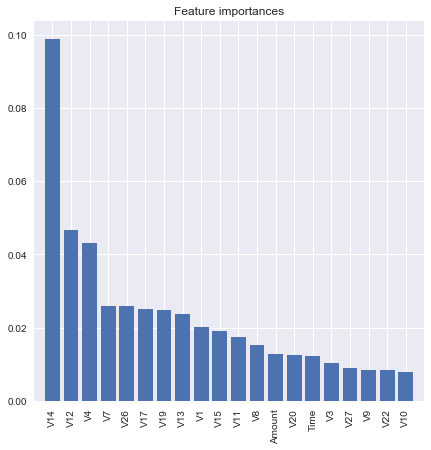

In [44]:
d_first = 20
plt.figure(figsize=(7,7))
plt.title("Feature importances")
plt.bar(range(d_first), importances[indices[:d_first]], align='center')
plt.xticks(range(d_first), np.array(feature_names)[indices[:d_first]], rotation=90)
plt.xlim([-1, d_first]);

### Перебор признаков с помощью лучшей модели:
Начинаем с полного пространства признаков, выбрасываем по одному признаку пока не портится качество модели на кросс-валидации либо пока не достигнем требуемого числа признаков (10)

In [45]:
selector = SequentialFeatureSelector(final_model3, scoring='roc_auc', verbose=2, k_features=10, forward=False, cv=Kf, n_jobs=-1)

In [46]:
selector.fit(X_train.values, y_train.values)


[2017-06-15 22:41:18] Features: 29/10 -- score: 0.987258830865
[2017-06-15 22:42:41] Features: 28/10 -- score: 0.987304384018
[2017-06-15 22:44:13] Features: 27/10 -- score: 0.987714659388
[2017-06-15 22:45:48] Features: 26/10 -- score: 0.988891191559
[2017-06-15 22:47:19] Features: 25/10 -- score: 0.988927555102
[2017-06-15 22:48:49] Features: 24/10 -- score: 0.989367274224
[2017-06-15 22:50:13] Features: 23/10 -- score: 0.988748642689
[2017-06-15 22:51:32] Features: 22/10 -- score: 0.988627617266
[2017-06-15 22:52:46] Features: 21/10 -- score: 0.989120786614
[2017-06-15 22:53:58] Features: 20/10 -- score: 0.9901098846
[2017-06-15 22:55:03] Features: 19/10 -- score: 0.989172239136
[2017-06-15 22:56:02] Features: 18/10 -- score: 0.989238658683
[2017-06-15 22:56:59] Features: 17/10 -- score: 0.98955239877
[2017-06-15 22:57:53] Features: 16/10 -- score: 0.98941217862
[2017-06-15 22:58:42] Features: 15/10 -- score: 0.989783390891
[2017-06-15 22:59:25] Features: 14/10 -- score: 0.98953665

SequentialFeatureSelector(clone_estimator=True,
             cv=sklearn.cross_validation.StratifiedKFold(labels=[0 0 ..., 0 0], n_folds=3, shuffle=True, random_state=2),
             estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.25, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=200, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
             floating=False, forward=False, k_features=10, n_jobs=-1,
             pre_dispatch='2*n_jobs', scoring='roc_auc',
             skip_if_stuck=True, verbose=2)

In [48]:
selector_metrics = pd.DataFrame.from_dict(selector.get_metric_dict()).T

In [49]:
selector_metrics

,avg_score,ci_bound,cv_scores,feature_idx,std_dev,std_err
10,0.989266,0.00563375,"[0.985725797929, 0.99100992874, 0.991062811513]","(3, 4, 6, 7, 12, 13, 14, 15, 19, 21)",0.00250352,0.00177026
11,0.99033,0.0052001,"[0.988420788417, 0.993581353535, 0.988987162707]","(3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 28)",0.00231082,0.00163399
12,0.989973,0.00534917,"[0.986881737476, 0.992662515369, 0.990375335475]","(3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 22, 28)",0.00237706,0.00168084
13,0.989486,0.00252668,"[0.988354734728, 0.991016539087, 0.989086317905]","(3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 22, 24, 28)",0.0011228,0.000793941
14,0.989537,0.00338959,"[0.987905569647, 0.991538756462, 0.989165642063]","(3, 4, 6, 7, 12, 13, 14, 15, 18, 19, 21, 22, 2...",0.00150626,0.00106509
15,0.989783,0.00477128,"[0.988110336081, 0.99277489126, 0.988464945332]","(3, 4, 6, 7, 10, 12, 13, 14, 15, 18, 19, 21, 2...",0.00212026,0.00149925
16,0.989412,0.00371349,"[0.987836213274, 0.991690794431, 0.988709528153]","(3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 18, 19, 21...",0.0016502,0.00116687
17,0.989552,0.00520267,"[0.986637338829, 0.992292335964, 0.989727521517]","(3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 18, 19, 21...",0.00231196,0.0016348
18,0.989239,0.00713241,"[0.985636625449, 0.993349991407, 0.988729359193]","(3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 18, 19,...",0.00316949,0.00224117
19,0.989172,0.00457361,"[0.986894948214, 0.991829611708, 0.988792157485]","(1, 3, 4, 5, 6, 7, 9, 10, 12, 13, 14, 15, 18, ...",0.00203242,0.00143714


In [50]:
X_train.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')

In [51]:
print('Best combination of features: (AUC ROC score: %.5f): %s\n' % (selector.k_score_, selector.k_feature_idx_))
print('All subsets of features: \n', selector.subsets_)

Best combination of features: (AUC ROC score: 0.98927): (3, 4, 6, 7, 12, 13, 14, 15, 19, 21)

All subsets of features: 
 {10: {'avg_score': 0.98926617939386674, 'feature_idx': (3, 4, 6, 7, 12, 13, 14, 15, 19, 21), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 11: {'avg_score': 0.99032976821948215, 'feature_idx': (3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 28), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 12: {'avg_score': 0.98997319610678725, 'feature_idx': (3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 22, 28), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 13: {'avg_score': 0.989485863906717, 'feature_idx': (3, 4, 6, 7, 12, 13, 14, 15, 19, 21, 22, 24, 28), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 14: {'avg_score': 0.98953665605719321, 'feature_idx': (3, 4, 6, 7, 12, 13, 14, 15, 18, 19, 21, 22, 24, 28), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 15: {'avg_score': 0.98978339089113365, 'feature_idx': (3, 4, 6, 7, 10, 12, 13, 14, 15, 18, 19, 21, 22, 24, 28), 'cv_scores': array([ 0.99,  0.99,  0.99])}, 16: 